# Iteration 3

## Targets:
- Reduce parameters to less than 10k by adding GAP
- add Dropout for regularization
- Add step LR
## Results: 
```
Total params: 9,930
Best results obtained in epoch: 29
Test accuracy: 99.38
Train accuracy: 98.88333333333334
```
## Analysis:
- We are very close to the target, with 9,930 params we under 10k parameter bound
- Dropout has reduced the gap between training and testing accuracy to a great deal but training accuracy is way behind test accuracy, maybe reduce the dropout value a bit ?
- Step LR seems to have helped

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:

class ConvReluBatchNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=(3,3), dropout=0.15, padding=0, **kwargs):
    super(ConvReluBatchNorm, self).__init__()
    self.convblock = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, bias=False, **kwargs),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.convblock(x)

In [4]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ConvReluBatchNorm(in_channels=1, out_channels=10) # in = 28 , out = 26, RF = 3
        self.conv2 = ConvReluBatchNorm(in_channels=10, out_channels=16)# in = 26 , out = 24, RF = 5
        self.conv3 = ConvReluBatchNorm(in_channels=16, out_channels=24, dropout=0) # in = 24 , out = 22, RF = 7
        self.pool1 = nn.MaxPool2d(2, 2) # in = 22 , out = 11, RF = 14
        # 1x1 to reduce channels
        self.transition_1 = ConvReluBatchNorm(in_channels=24, out_channels=8, kernel_size=(1,1)) # in = 11 , out = 9, RF = 16
        # normal 3x3 to increase channels
        self.conv4 = ConvReluBatchNorm(in_channels=8, out_channels=12) # in = 9 , out = 7, RF = 18
        self.conv5 = ConvReluBatchNorm(in_channels=12, out_channels=14) # in = 7 , out = 5, RF = 20
        self.conv6 = ConvReluBatchNorm(in_channels=14, out_channels=16) # in = 5 , out = 3, RF = 22
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=5))
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) # in = 3 , out = 1, RF = 28

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.transition_1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.gap(x)
        x = self.conv7(x)
        

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [5]:
# in = 22 , out = 11, RF = 14!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
 ConvReluBatchNorm-5           [-1, 10, 26, 26]               0
            Conv2d-6           [-1, 16, 24, 24]           1,440
              ReLU-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
           Dropout-9           [-1, 16, 24, 24]               0
ConvReluBatchNorm-10           [-1, 16, 24, 24]               0
           Conv2d-11           [-1, 24, 22, 22]           3,456
             ReLU-12           [-1, 24, 22, 22]               0
      BatchNorm2d-13           [-1, 24, 22, 22]              48
          Dropout-14           [-1, 24,

In [6]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


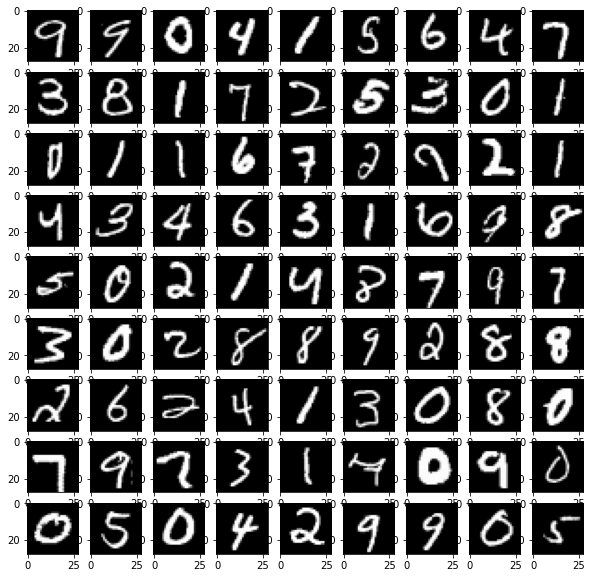

In [7]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(9*9):
    plt.subplot(9,9,i+1)   
    imgs, lbls = next(iter(train_loader))
    plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray") 
    # plt.imshow(img[i,:,:16])

plt.show()

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_epoch = []
train_loss_epoch = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)
      train_loss_epoch.append(loss.item())    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
from torch.optim.lr_scheduler import StepLR

acc_thresh = 99.94
EPOCHS = 15

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    if test_acc[-1] >= acc_thresh:
      print(f"HURRAY, You did it !!!!")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.19229178130626678 Batch_id=468 Accuracy=85.07: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0999, Accuracy: 9749/10000 (97.49%)

EPOCH: 1


Loss=0.09210404753684998 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.16835379600524902 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.038947004824876785 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.07932602614164352 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.030567066743969917 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.0361708402633667 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.12825994193553925 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


Loss=0.13857512176036835 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.04074922949075699 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.012546565383672714 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.06575875729322433 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.018483294174075127 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.003868026426061988 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.026753708720207214 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]



Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)



In [17]:
best_epoch = np.argmax(test_acc)
print(f"Best results obtained in epoch: {best_epoch}")
print(f'Test accuracy: {max(test_acc)}\nTrain accuracy: {train_acc_epoch[best_epoch]}')

Best results obtained in epoch: 29
Test accuracy: 99.38
Train accuracy: 98.88333333333334


Text(0.5, 1.0, 'Test Accuracy')

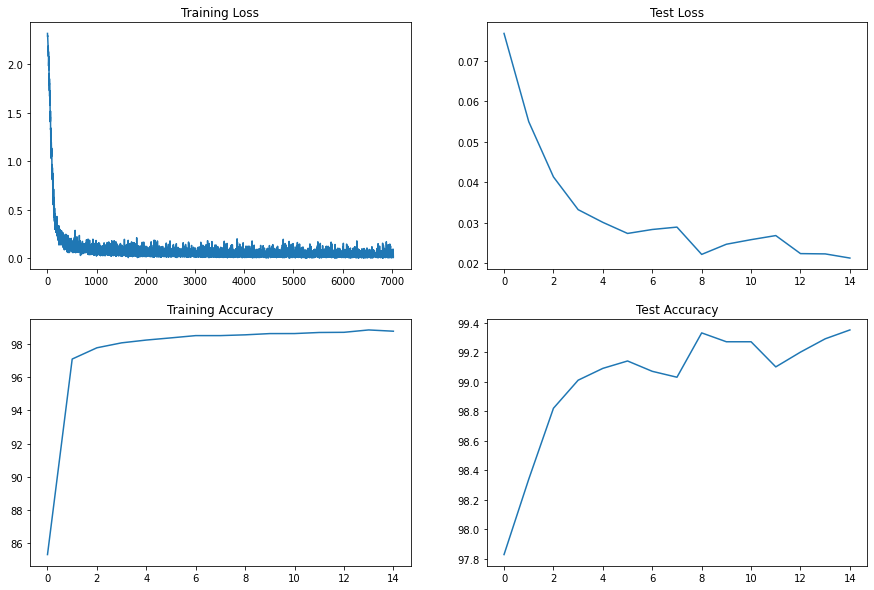

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_epoch)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")